In [1]:
import numpy as np
import xarray as xr
import scipy
import gdal
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
import timeit
from fractions import Fraction


import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline

input_DEM_resolution = 1
initial_resolution = 9

threshold_lists = {1:['Thresholds', 128, 64, 32, 16, 8, 4, 2, 1],
                   3:['Thresholds', 64, 32, 16, 8, 4, 2, 1], 
                   9:['Thresholds', 32, 16, 8, 4, 2, 1, 0] , 
                   27:['Thresholds', 16, 8, 4, 2, 1, 0]}

### Setup function to ensure data is correct shape for resampling

In [2]:
def x_y_size_test(input_array, resolution_ratio, resample_levels, number_of_options):
    
    """This function checks the size of the array and ensures that it can be resampled up and down 
    by a factor of three and always result in an array of the original size."""
    
    # Check number of rows and columns. 
    rows = np.size(input_array, 0)
    columns = np.size(input_array, 1)
    
    array_sizes = []
    for i in range(1,number_of_options):
        min_dim_size = resolution_ratio ** resample_levels
        ideal_array = i * min_dim_size
        array_sizes.append(ideal_array)

    ideal_row = next(x[1] for x in enumerate(array_sizes) if x[1] > rows)
    ideal_col = next(x[1] for x in enumerate(array_sizes) if x[1] > columns)
    
    add_rows = ideal_row - rows
    add_columns = ideal_col - columns
    
    empty_array = np.zeros((rows + add_rows, columns + add_columns)) # Create an empty array to the pad if required.
    
    offset_rows = int(-1 * add_rows)
    offset_columns = int(-1 * add_columns)
    
    empty_array[:offset_rows, :offset_columns] = input_array
    
    return empty_array

### Setup initial input data.

In [3]:
location = (r'C:/PhD/junk')
os.chdir(location)

In [4]:
ds = gdal.Open('fann_2013_1m.tif')
x = np.array(ds.GetRasterBand(1).ReadAsArray())
input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / initial_resolution, order = 1)
kernel = np.loadtxt('kernel.txt')
kernel_1d = np.reshape(kernel,(1,121))

### Create a mask to apply to final output

### NOTE: This process will be different depending on the nominal value for NoData in an input DEM.

The step below assumes that NoData values in the input DEM have some arbitrarily small value (usually less than zero) and these are then assigned to
np.copy is used below because if an array is just mapped to a variable then changes to the new array will also be made to the original array. Using np.copy creates a unique instance of the original array that can then be changed.

In [5]:
minimum = np.amin(input_DEM)
minimum
mask_template = np.copy(input_DEM)
mask_template[mask_template != minimum] = 1
mask_template[mask_template == minimum] = np.nan
mask = x_y_size_test(mask_template, 3, 5, 100)
mask

array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

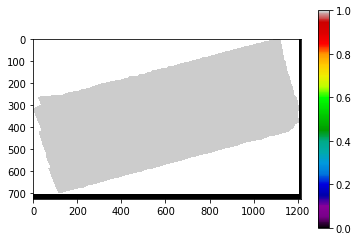

In [6]:
plt.imshow(mask, cmap="nipy_spectral")
plt.colorbar()

First check that the x axis y axis of the array are in multiples of the desired resolution ratio so that resampling up and down will always result in an output of equal size to the original input DEM.
In the case of MRVBF the reoslution ratio is 3 (but this can be varied).

In [7]:
# This will have the same problem as the mask. The == value will vary depending on the particular dataset.
DEM = x_y_size_test(input_DEM, 3, 5, 100)
DEM[DEM == minimum] = 0
DEM.shape

(729, 1215)

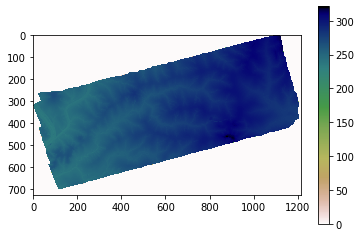

In [8]:
plt.imshow(DEM, cmap="gist_earth_r")
plt.colorbar()

### Setup process to calculate slope for input DEM

In [9]:
def rectangleWindow(m, n):
    
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    
    rectangle = np.ones((m, n), dtype=bool) 

    return rectangle
def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
        
    denominator = sum(sum(Window > 0))
    
    return denominator
def slopeWindow(DEM, x_cellsize, y_cellsize):
    
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
        
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
       
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    
    slope_percent = rise_run * 100
    
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

### Create a slope raster with slope represented as percent.

In [10]:
S1 = generic_filter(DEM, slopeWindow,
                    footprint= rectangleWindow(3,3), 
                    mode='constant',extra_arguments = (initial_resolution,initial_resolution,))

### Define a function to take the inverse of slope.

Note: the function below truncates slope to 100% before taking inverse. This puts a limit of 100% on the flatness requirement used by the algorithm. However, anything greater than 100% is probably not suitably flat in any case.

#### Now define a non-linear function for mapping  output values onto the range 0 to 1.

Equation 1: N(x, t, p) = 1 / (1 + (x/t)^p)

In [11]:
def Nxtp(x, t, p):
    
    """Takes a DEM derivative (x, such as slope or elevation percentile 
    and maps it onto the range [0,1] using a non-linear equation with a shape 
    parameter (t) and a threshold parameter (p)"""
    
    standardise_value = 1/(1+(x/t)**p)
    print (x)
    print (t)
    print (p)
    return standardise_value

## 2.3. Finest-Scale step

Equation 2: F1 = N(S1, t$_{s,1}$, 4)

In the paper the threshold value (t) at this stage is 16% but here it's set to 32% because I have 5m resolution and the threshold should increase with increasing resolution. 

In [12]:
%%capture
F1 = Nxtp(S1, threshold_lists[initial_resolution][1], 4)

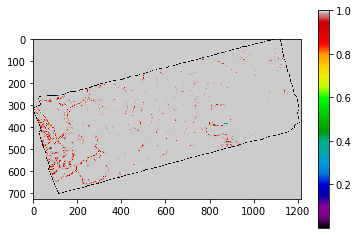

In [13]:
plt.imshow(F1, cmap="nipy_spectral")
plt.colorbar()

## Calculate elevation percentiles

Define three functions to isolate local neighborhoodsd of grid cells:

1. a function that takes a value for radius and creates a circular window using that radius.
2. a function that calculates the number of grid cells in the output of 1, and
3. a function that locates the central grid cell of the neighborhood.

In [14]:
def circleWindow(radius):
    
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == circle type 'number_of_values(circleWindow(r)) 
        where r is any positive real number as per the circleWindow function."""
        
    denominator = sum(sum(Window > 0))
    return denominator
def find_median_value(Window):
    
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer."""
    
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value

In [15]:
circleWindow(3)

array([[False, False, False,  True, False, False, False],
       [False,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False],
       [False, False, False,  True, False, False, False]])

In [16]:
number_of_values(circleWindow(3))

29

In [17]:
find_median_value(circleWindow(3))

14

Define a function to be used by the generic_filter function to calculate elevation percentile.

In [18]:
def PCTL(x):
    
    """This function only works as an inside function to generic_filter function below. This
    is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
    step the 'central_value' variable will be outside of the array dimensions. 
    x = input DEM and r = radius of search window """
    
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y

### Calculate elevation percentile using generic_filter with custom shape and input function.

Calculate elevation percentile with a radius of 3. Use percentile_filter from ndimage.

The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.

The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the input function (PCTL in this case) to take one argument (S1). Then, if the input function normally takes more than one argument the 'extra_arguments' variable needs to be defined as a tuple (hence (3,) instead of (3)).


In [19]:
radius = 3
central_value = find_median_value(circleWindow(radius));
num_values = number_of_values(circleWindow(radius));
PCTL1 = generic_filter(DEM, PCTL, footprint= circleWindow(radius), mode='nearest');

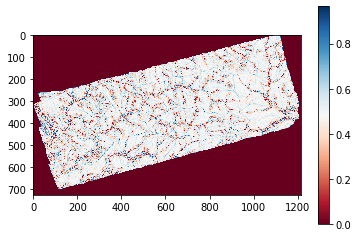

In [20]:
plt.imshow(PCTL1, cmap="RdBu")
plt.colorbar()

Equation 3: PVF$_{1}$ = F$_{1}$N(PCTL$_{1}$, 0.4, 3)

In [21]:
%%capture
PVF1 = F1 * Nxtp(PCTL1, 0.4, 3)

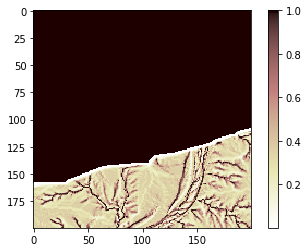

In [22]:
plt.imshow(PVF1[100:300, 100:300], cmap = "pink_r")
plt.colorbar()

Equation 4: VF$_{1}$ = 1 - Nxtp(PVF$_{1}$, 0.3, 4)

In [23]:
%%capture
VF1 = 1 - Nxtp(PVF1, 0.3, 4)

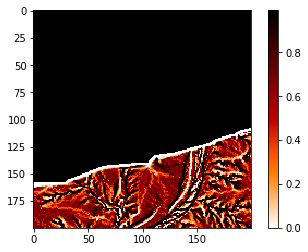

In [24]:
plt.imshow(VF1[100:300, 100:300], cmap="gist_heat_r")
plt.colorbar()

# 2.4. Second step

Equation 5: F$_{2}$ = N(S$_{2}$, t$_{s,2}$, 4)

In [25]:
S2 = np.copy(S1)

In [26]:
%%capture
F2 = Nxtp(S2,threshold_lists[initial_resolution][2],4)

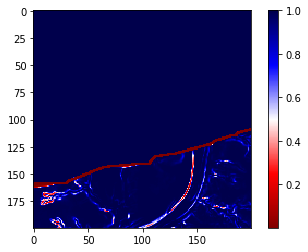

In [27]:
plt.imshow(F2[100:300, 100:300], cmap="seismic_r")
plt.colorbar()

#### Calculate elevation percentile with a radius of 6.


In [28]:
radius = 6
central_value = find_median_value(circleWindow(radius))
num_values = number_of_values(circleWindow(radius))
PCTL2 = generic_filter(DEM, PCTL, footprint= circleWindow(radius), mode='constant')

Equation 6: PVF$_{2}$ = F$_{2}$N(PCTL$_{2}$, 0.4, 3)

In [29]:
%%capture
PVF2 = F2 * Nxtp(PCTL2, 0.4, 3)

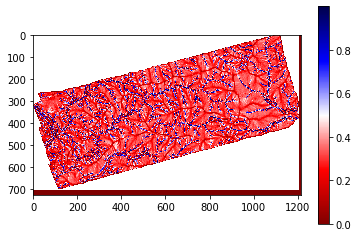

In [30]:
plt.imshow(PVF2 * mask, cmap="seismic_r")
plt.colorbar()

Equation 7: VF$_{2}$ = 1 - N(PVF$_{2}$, 0.3, 4)

In [31]:
%%capture
VF2 = 1 - Nxtp(PVF2, 0.3, 4)

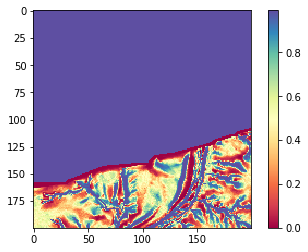

In [32]:
plt.imshow(VF2[100:300, 100:300], cmap="Spectral")
plt.colorbar()

Equation 9: W$_{2}$ = 1 - N(VF$_{2}$, t, p$_{2}$)

Note: Equation 9 is being defined before equation 8 because it is a required input to equaiton 8.

In [33]:
%%capture
W2 = 1 - Nxtp(VF2, 0.4, 6.68)

t = 0.5 and p2 = 6.68 are parameter values taken stright from the paper but can be varied.

Equation 8: MRVBF$_{2}$ = W$_{2}$(1 + VF$_{2}$) + (1 - W$_{2}$)VF$_{1}$)

In [34]:
MRVBF2 = W2 * (1 + VF2) + (1 - W2)*VF1

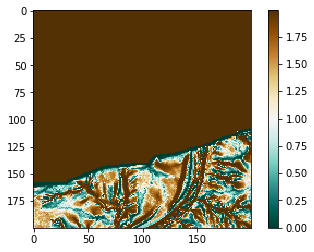

In [35]:
plt.imshow(MRVBF2[100:300, 100:300], cmap= "BrBG_r")
plt.colorbar()

Equation 10: CF$_{2}$ = F$_{1}$F$_{2}$

In [36]:
CF2 = F1*F2

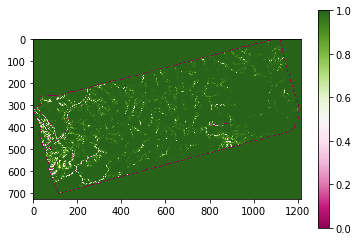

In [37]:
plt.imshow(CF2, cmap="PiYG")
plt.colorbar()

# 2.5. Remaining steps.

#### First setup functions for changing resolution of data

In [38]:
def resample_resolution_lower(data, ratio):
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    zoom_factor = Fraction(1,3 ** ratio)
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    return resample
def resample_resolution_higher(data, ratio):
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    zoom_factor = 3 ** ratio
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    return resample

#### Now define a function do smooth the DEM

In [39]:
def gaussian_filter(image, kernel):
    """This function applies a gaussian smoothing filter to the data. It takes an input DEM
    and kernel file (read in as a numpy array). This is the exact same filter used by MRVBF"""
    convolution = np.mean(np.multiply(kernel, image))
    return convolution

#### Create a dictionary object and assign an initial set of inputs to the dictionary

In [40]:
array_LL = {}
array_LL.setdefault('DEM22', []).append(DEM);
array_LL.setdefault('F21', []).append(F2); 
array_LL.setdefault('CF21', []).append(CF2); 
array_LL.setdefault('MRVBF21', []).append(MRVBF2);

Begin a loop with 3 as the smallets value. This corresponds to DEM3,2 being a smoothed version of the initial input DEM and hence the smallets value for this next section is 3. The maximum value is 5 and this corresponds to a maximum grid cell resolution 243m.

In [41]:
%%capture
for i in range(3,6): 
    L = str(i) 
    Lm1 = str(i - 1)
    DEMLm1_Lm1 = np.copy(array_LL['DEM'+ Lm1 + Lm1][0])
    DEML_Lm1 = generic_filter(DEMLm1_Lm1, gaussian_filter, 
                              footprint= rectangleWindow(11,11), 
                              mode='nearest', extra_arguments = (kernel_1d,))
    array_LL.setdefault('DEM'+ L + Lm1, []).append(DEML_Lm1);
    # Derive slope SL, L-1 from smoothed DEM and resample to base resolution (SL, 1)
    # This resolution is only correct if the starting DEM is 9m resolution.
    slope_resolution = 3**(int(L) - 1);
    SL_Lm1 = generic_filter(array_LL['DEM'+ L + Lm1][0], slopeWindow, 
                            footprint= rectangleWindow(3,3), 
                            mode='nearest', 
                            extra_arguments = (slope_resolution,slope_resolution,))
    # Resample the data (refine SL, L-1 to base resolution).
    if L == str(3):
        SL_1 = np.copy(SL_Lm1) 
    else:
        #Set the zoom factor.
        zf = i - 3
        SL_1 = resample_resolution_higher(SL_Lm1, zf)
    # Resample (coarsen) smoothed DEM to current step (DEM  L, L).
    DEML_L = resample_resolution_lower(DEML_Lm1, 1)
    # This will always just be one because every step is just incrementally decreasing resolution by 1 * resolution ratio.
    array_LL.setdefault('DEM'+ L + L, []).append(DEML_L);
    # Now calculate PCTL L,L from coarsened DEM using a window size of 6 cells.
    # Set radius of circle window.
    radius = 6
    # Set variables required for PCTL function.
    central_value = find_median_value(circleWindow(radius))
    num_values = number_of_values(circleWindow(radius))
    PCTLL_L = generic_filter(DEML_L, PCTL, footprint= circleWindow(radius), mode='constant')
    # Now resample PCTL L, L back to base resolution (PCTL L, 1)
    #Set the zoom factor.
    zf = i - 2
    PCTLL_1 = resample_resolution_higher(PCTLL_L, zf)
    # Now calculate flatness FL,1 at the base resolution and slope threshold for step L.
    FL_1 = Nxtp(SL_1,threshold_lists[initial_resolution][int(L)],4) # Equation (12)
    # Now mulitply FL,1 by combined flatness from previous step to give CF L, 1
    # Formula from paper CF L, 1 = (CF L-1, 1) * (F L, 1) 
    CFL_1 = array_LL['CF'+ Lm1 + '1'][0] * FL_1 # Equation (13)
    array_LL.setdefault('CF'+ L + '1', []).append(CFL_1);
    # Now calculate preliminary valley bottom flatness for step L.
    # PVF L, 1 = CF L, 1 N(PCTL L, 1, 0.4, 3)
    PVFL_1 = CFL_1 * Nxtp(PCTLL_1, 0.4, 3) # Equation (14)
    # Now calculate valley flatness index
    # VF L, 1 = 1 - N(PVF L, 1, 0.3, 4)
    VFL_1 = 1 - Nxtp(PVFL_1, 0.3, 4) # Equation (15)
    # Now compute MRVBF L, 1 using VF L, 1 and MRVBF L - 1, 1 and weighting described in step 2.
    # First calculate pl. Use pl = log(L-0.5/0.1)/log(1.5)
    pl = (math.log((int(L) - 0.5)/0.1)) / math.log(1.5) # Equation (18)
    # Now calculate weight. W L,1 = 1 - N(VF L,1, t, pl)
    WL_1 = 1 - Nxtp(VFL_1, 0.4, pl) # Equation (17)
    # MRVBF L, 1 = W L,1(L -1 + VF L,1) + (1 - W L,1)MRVBF L-1, 1.
    # Equation (16)
    MRVBFL_1 = (WL_1 * ((int(L)) - 1 + VFL_1)) + ((1 - WL_1) * array_LL['MRVBF'+ Lm1 + '1'][0])
    array_LL.setdefault('MRVBF'+ L + '1', []).append(MRVBFL_1);


In [42]:
MRVBF_max = np.copy(array_LL['MRVBF51'][0])
np.amax(MRVBF_max)

4.991766955497726

In [43]:
MRVBF = resample_resolution_higher(MRVBF_max, 2)

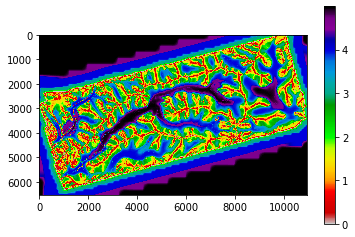

In [44]:
plt.imshow(MRVBF, cmap="nipy_spectral_r")
plt.colorbar()

In [45]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = ds.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [46]:
np_array_to_Geotiff('fann_mrvbf.tif', ds, MRVBF, PCTL1.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
